# MA5851 Data Science Masterclass 1
### Assignment 3: Webcrawler and NLP System
### Laura Vodden

## Step 1. Twitter Scraper using Selenium
### The aim of this exercise is to extract STEM-related Tweets containing gender pronouns to investigate gender bias that may affect machine learning models.

In [1]:
import pandas as pd
import numpy as np
from getpass import getpass
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from webdriver_manager.chrome import ChromeDriverManager
import csv
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt

In [2]:
def get_tweet_data(card):
    #Extract tweet data
    #username
    try:
        username = card.find_element_by_xpath('.//span').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #twitter handle
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #tweet text
    try:
        comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
        responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
        text = comment+responding
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #reply count
    try:
        comment = card.find_element_by_xpath('//div[@data-testid="reply"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #retweet count
    try:
        retweet = card.find_element_by_xpath('//div[@data-testid="retweet"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    #likes
    try:
        like = card.find_element_by_xpath('//div[@data-testid="like"]').text
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    try:
        #post date
        date = card.find_element_by_xpath('.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    except StaleElementReferenceException:
        return
    
    tweet = (username, handle, text, comment, retweet, like, date)
    return tweet 

# create instance of webdriver
driver = webdriver.Chrome()
driver.get('https://www.twitter.com/login')


In [3]:
#navigate to twitter and login
username = driver.find_element_by_xpath('//input[@name="session[username_or_email]"]')
username.send_keys('email')
mypassword = getpass()

password = driver.find_element_by_xpath('//input[@name="session[password]"]')
password.send_keys(mypassword)
password.send_keys(Keys.RETURN)


········


In [5]:
#find search input and search for term

#navigte to 'explore' tab
driver.find_element_by_xpath('//a[@data-testid="AppTabBar_Explore_Link"]').click()

search_input = driver.find_element_by_xpath('//input[@aria-label="Search query"]')
search_input.send_keys('(science OR technology OR engineering OR math OR mathematics OR scientist OR technologist OR engineer OR mathematician) (she OR her OR he OR him) -filter:retweets')
search_input.send_keys(Keys.RETURN)

#navigte to 'latest' tab
driver.find_element_by_link_text('Latest').click()

# get all tweets on the page
data = []
tweet_ids = set()
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
    for card in page_cards[-15:]:
        tweet = get_tweet_data(card)
        if tweet:
            tweet_id = ''.join(tweet)
            if tweet_id not in tweet_ids:
                tweet_ids.add(tweet_id)
            data.append(tweet)
    
    scroll_attempt = 0
    while True:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(1)
        curr_position = driver.execute_script("return window.pageYOffset;")
        if last_position == curr_position:
            scroll_attempt += 1
            
            #end of scroll region
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2) # attempt to scroll again
        else:
            last_position = curr_position
            break

#save tweet data
with open('stem_tweets_2.csv', 'w', newline='', encoding='utf-8') as f:
    header = ['Username', 'Handle', 'Text', 'Comments', 'Retweets', 'Likes', 'Date']
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)

## Step 2. Data cleaning

In [32]:
tweets_df = pd.read_csv("stem_tweets.csv", dtype=object)
tweets_df.head()

,Username,Handle,Text,Comments,Retweets,Likes,Date
0,Angi,@AngiMaryssa,"Blackwell is great. As a lawyer, you have to b...",NaN,NaN,NaN,2021-04-14T20:32:29.000Z
1,Señor Luis (1LUV),@thiccbb69,"math dumb af, if y=mx+b then y=tf don't she lo...",NaN,NaN,NaN,2021-04-14T20:32:24.000Z
2,Jared Halpern,@JaredEHalpern,"Wow, he was a hell of an engineer --Grant Imah...",NaN,NaN,NaN,2021-04-14T20:32:23.000Z
3,Bob Brigham,@BobBrigham,Matt Kelley is so bad he thinks coronavirus is...,NaN,NaN,NaN,2021-04-14T20:32:10.000Z
4,AlaskanTzar,@AlaskanTzar,Replying to \n@science_bradyBut he was?,NaN,NaN,NaN,2021-04-14T20:31:58.000Z


In [33]:
len(tweets_df)

30284

In [34]:
# Remove handles
tweets_df['Text'] =  tweets_df['Text'].apply(lambda x: re.sub('@[\w]+','', str(x)))


#Remove punctuation

# remove 's, 'll, 'd  
tweets_df['Text'] = tweets_df['Text'].str.replace("'s","")
tweets_df['Text'] = tweets_df['Text'].str.replace("'ll","")
tweets_df['Text'] = tweets_df['Text'].str.replace("'d","")
tweets_df['Text'] = tweets_df['Text'].str.replace("Replying to ","")
tweets_df['Text'] = tweets_df['Text'].str.replace("\n","")
 


def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

tweets_df['Text']=tweets_df['Text'].apply(lambda x: remove_punctuation(x))



# Tokenizing 
def tokenize(text):
    split=re.split("\W+",text) 
    return split
tweets_df['Text_Token']=tweets_df['Text'].apply(lambda x: tokenize(x.lower()))


# Assign a gender to each tweet based on pronouns present
tweets_df.loc[tweets_df['Text'].str.contains(' he '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains('He '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains(' him '), 'Gender'] = 'M'
tweets_df.loc[tweets_df['Text'].str.contains(' she '), 'Gender'] = 'F'
tweets_df.loc[tweets_df['Text'].str.contains('She'), 'Gender'] = 'F'
tweets_df.loc[tweets_df['Text'].str.contains(' her '), 'Gender'] = 'F'

# Remove stop words
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text
tweets_df['Text_Token'] = tweets_df['Text_Token'].apply(lambda x: remove_stopwords(x))

# Lemmatizing
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

tweets_df['Text_Token'] = tweets_df['Text_Token'].apply(lemmatize_text)
#tweets_df['Text_Token'] = tweets_df['Text_Token'].str.replace("'',","")


tweets_df = tweets_df[["Username","Handle","Text","Date","Text_Token","Gender"]]


# Drop any rows containing blanks
tweets_df = tweets_df.replace(r'^\s*$', np.nan, regex=True)
tweets_df = tweets_df.dropna()

In [35]:
tweets_df.head()

,Username,Handle,Text,Date,Text_Token,Gender
0,Angi,@AngiMaryssa,Blackwell is great As a lawyer you have to bec...,2021-04-14T20:32:29.000Z,"[blackwell, great, lawyer, become, expert, com...",M
1,Señor Luis (1LUV),@thiccbb69,math dumb af if ymxb then ytf dont she love me,2021-04-14T20:32:24.000Z,"[math, dumb, af, ymxb, ytf, dont, love]",F
2,Jared Halpern,@JaredEHalpern,Wow he was a hell of an engineer Grant Imahara...,2021-04-14T20:32:23.000Z,"[wow, hell, engineer, grant, imahara, talk, ro...",M
3,Bob Brigham,@BobBrigham,Matt Kelley is so bad he thinks coronavirus is...,2021-04-14T20:32:10.000Z,"[matt, kelley, bad, think, coronavirus, noctur...",M
4,AlaskanTzar,@AlaskanTzar,he was,2021-04-14T20:31:58.000Z,[],M


In [36]:
len(tweets_df)

25165

In [37]:
# Save to csv
tweets_df.to_csv ('tweets_df_with_gender.csv', index = None, header=True)

## Step 3. Data exploration

Percentage of STEM Tweets by gender
M    0.65909
F    0.34091
Name: Gender, dtype: float64

Count of STEM Tweets by gender
M    16586
F     8579
Name: Gender, dtype: int64

Total Tweets: 25165


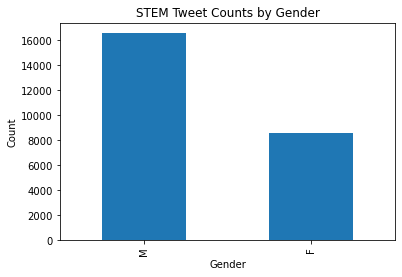

In [38]:
# Count tweets about women vs men
print("Percentage of STEM Tweets by gender")
counts = tweets_df['Gender'].value_counts(normalize=True)
print(counts)
print()
print("Count of STEM Tweets by gender")
counts = tweets_df['Gender'].value_counts()
print(counts)
print()
print("Total Tweets:", len(tweets_df))
tweets_df.Gender.value_counts().plot(kind = 'bar')
plt.title('STEM Tweet Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


## Step 4. Gender prediction

In [46]:
documents = tweets_df["Text_Token"]

print(documents)

0        [blackwell, great, lawyer, become, expert, com...
1                  [math, dumb, af, ymxb, ytf, dont, love]
2        [wow, hell, engineer, grant, imahara, talk, ro...
3        [matt, kelley, bad, think, coronavirus, noctur...
4                                                       []
                               ...                        
30278                                       [, two, match]
30279    [forgot, ran, young, female, gas, engineer, ap...
30280    [, p, farrellone, world, brilliant, mind, lost...
30282    [built, pergola, yaay, draw, want, discus, fin...
30283    [blessed, mindhe, first, taught, usthat, cosmo...
Name: Text_Token, Length: 25165, dtype: object
